In [3]:
"""
 a SLP project using labeled frames from Label3D - com_net model
----------------------------------------------------
**This notebook takes labeled training data from Label3D and packages it into a SLP project to train the com_net model on the coarse bird location (head, body, tail).**

Reformat 3D points from Label3D into an array of 2D points
Then, pass through `create_slp_project()` to make the SLP project file.

The coarse predictions are then used to crop around the bird (posture net) and the head (face net) to predict the detaied keypoints and seed presence, respectively, on cropped video frames.
"""
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import mat73
import scipy
import os 
import sys
sys.path.append("C:/Users/xl313/OneDrive/Documents/GitHub/poseTrackingXL/utils")
from slp_utils_XL import create_slp_project, resize_and_pad_rows
sys.path.append("../camera_calibration/")
sys.path.append("C:/Users/xl313/OneDrive/Documents/GitHub/poseTrackingXL/pySBA")
import pySBA

In [5]:
''' Locate directories: UPDATE AS-APPROPRIATE '''
proj_date = "031225"
# for downsampling
ds_fac = 4
# skeleton file (nodes and edges)
skeleton_file = 'C:/Users/xl313/OneDrive/Documents/GitHub/poseTrackingXL/comNet/com_skeleton_IL.csv'
# to save SLP project
slp_project_dir = 'Z:/Sherry/poseTrackingXL/training_files/SLP/'
slp_project_file = f'{proj_date}_com_net.slp'
slp_project_path = f'{slp_project_dir}{slp_project_file}'
# location where trained images will be stored
training_vid_dir = "Z:/Sherry/poseTrackingXL/training_files/com_vids/"
vid_file = f'{proj_date}_com_vid.npy'
training_vid_path = f'{training_vid_dir}{vid_file}'
# Label3D training data
training_dir = 'Z:/Sherry/poseTrackingXL/training_files/Label3D/'
training_files = []
for f in os.listdir(training_dir):
    if 'sleap' in f:
        training_files.append(f)

training_files, len(training_files)

(['ROS103_092324_2_800_trainingOnly_sleap.mat',
  'AMB155_100424_02_5_start195000_end270000_sleap.mat',
  'AMB155_100424_02_6_start6000_end96000_sleap.mat',
  'ROS103_092324_8_400_trainingOnly_sleap.mat',
  'AMB155_100424_02_25_start99020_end231020_sleap.mat',
  'SLV123_110824_wEphys_15_start63000_end120000_sleap.mat',
  'ROS103_092324_5_700_trainingOnly_sleap.mat',
  'AMB155_100424_02_10_start66015_end264015_sleap.mat',
  'SLV123_110824_wEphys_24_start135000_end300000_sleap.mat',
  'ROS103_092324_5_500_trainingOnly_sleap.mat',
  'SLV123_110824_wEphys_10_start6000_end60000_sleap.mat'],
 11)

In [6]:
''' Functions '''
def avgBodyParts(data3D):
    """
    averages across the labeled points for each coarse region:
    - head: left eye, right eye (7, 11)
    - body: center back, base tail, left wing, right wing (4, 5, 8, 12)
    - tail: tip tail (6)
    """
    headInd = [7, 11] 
    bodyInd = [4, 5, 8, 12]
    tailInd = [6]
    nFrames = data3D.shape[0]
    nParts = data3D.shape[1]//3
    data3D = np.reshape(data3D, (nFrames, nParts, 3))
    headPts = np.mean(data3D[:, headInd], axis=1)
    bodyPts = np.mean(data3D[:, bodyInd], axis=1)
    tailPts = np.mean(data3D[:, tailInd], axis=1)
    return (headPts, bodyPts, tailPts)

In [7]:
def projectData(matfile):
    '''
    the purpose of this is to reproject 3D points onto 2D camera views again
    takes in a matfile from Label3D which contains
    - camera params
    - 3D point locations
    reshapes 3D data to (n_frames, n_nodes, 3)
    - averages across head, body, and tail regions
    reprojects onto each camera view to get an array of shape (n_frames, n_cams, n_nodes, 2) 
    '''
    camParams = pySBA.convertParams(matfile['camParams'])
    pt3d = avgBodyParts(matfile['data_3D'])
    sba = pySBA.PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN) #points_2d[:, :2], camera_ind, point_2dind3d, points_2d[:, 2])
    nFrames = pt3d[0].shape[0]
    nParts = len(pt3d)
    nCams = camParams.shape[0]
    allLabels = np.full((nFrames, nCams, nParts, 2), np.NaN)
    for nCam in range(nCams):
        for nPart in range(nParts):
            allLabels[:, nCam, nPart, :] = sba.project(pt3d[nPart], np.tile(camParams[nCam],(nFrames,1))) # this convert 3d points to 2d by projecting onto images

    return allLabels

In [ ]:
''' Get coarse 3D points and reformat into an array of 2D points '''
all_labels = [] # (n_frames, n_cams, n_nodes, 2)
all_images = [] # CHECK SHAPE
for fn in training_files:
    print(fn)
    file_path = f"{training_dir}{fn}"
    matfile = mat73.loadmat(file_path)
    labels = projectData(matfile)
    images = []
    for i in matfile['label_frames']:
            images.append(i[0])
    #all_labels = np.concatenate(labels, axis=0)
    all_images.append(np.array(images))
    all_labels.append(np.array(labels))

ROS103_092324_2_800_trainingOnly_sleap.mat
AMB155_100424_02_5_start195000_end270000_sleap.mat
AMB155_100424_02_6_start6000_end96000_sleap.mat
ROS103_092324_8_400_trainingOnly_sleap.mat
AMB155_100424_02_25_start99020_end231020_sleap.mat


images

In [34]:
# reformat
all_labels = np.concatenate(all_labels, axis=0) # got rid of the 1 on first dimension
n_cams = all_labels.shape[1] # 4 cameras 
all_cams = [] # list (len (n_cams,)) of arrays (w, h, RGB, n_frames)
for c in range(n_cams):
    these_images = np.concatenate([i[c] for i in all_images], axis=3)
    all_cams.append(np.squeeze(these_images))

In [37]:
# define the downsampled image size
im_w = all_cams[0].shape[0]
im_h = all_cams[0].shape[1]
ds_size = (im_w//ds_fac, im_h//ds_fac) # pixels - need to adjust

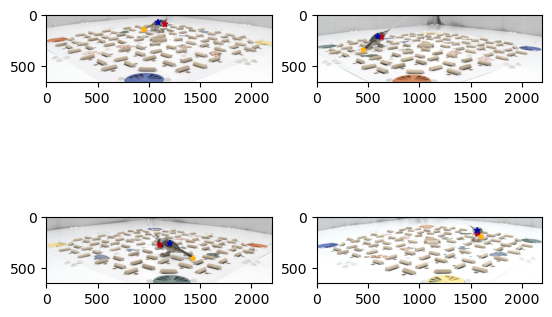

<Figure size 640x480 with 0 Axes>

In [38]:
''' plot a frame to check output '''
ex_frame = 1
# fig params
f, ax = plt.subplots(n_cams//2, 2)
colors = ['xkcd:scarlet', 'xkcd:cobalt blue', 'xkcd:saffron']
# plot for each camera
for n_cam in range(n_cams):
    # get subplot index
    if n_cam < n_cams//2:
        r = n_cam
        c = 0
    else:
        r = n_cam - n_cams//2
        c = 1
    # label keypoints
    ax[r, c].imshow(images[n_cam][:, :, :, ex_frame]) # 
    ax[r, c].scatter(labels[ex_frame, n_cam, :, 0], 
                     labels[ex_frame, n_cam, :, 1],
                     c=colors, marker='*', s=15)
plt.show()
plt.tight_layout()

In [39]:
''' concatenate across camera views and downsample '''
label_data = [] # shape (total_frames, n_nodes, 2) # nodes are  the average body parts (head, body, tail)
image_data = [] # shape (total_frames, ds_h, ds_w, RGB) from (ds_w,ds_h,RGB,total_frames)

In [40]:
for n_cam in range(n_cams):
    images = np.transpose(all_cams[n_cam], axes=[3,1,0,2]) 
    labels = all_labels[:, n_cam]
    n_frames = labels.shape[0]
    for f in range(n_frames):
        #if np.isfinite(labels[f].sum()):
        ds_ann = labels[f] / ds_fac
        ds_im = cv2.resize(images[f], ds_size,
                            interpolation=cv2.INTER_AREA)
        label_data.append(ds_ann)
        image_data.append(ds_im)
label_data = np.stack(label_data, axis=0)
image_data = np.stack(image_data, axis = 0)
image_data = np.transpose(image_data,(0,2,1,3))
#label_data = np.asarray(label_data)
#image_data = np.asarray(image_data)
np.save(training_vid_path, image_data)

In [42]:
# convert into a SLP project file
create_slp_project(vid_path=training_vid_path, 
                   skeleton_file=skeleton_file,
                   keypoints=label_data,
                   slp_labels_file=slp_project_path)